In [ ]:
!pip install -q transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's de

In [ ]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

2025-08-06 04:04:36.136797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754453076.323453      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754453076.373987      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def compute_metrics(eval_pred: EvalPrediction):
    """Compute accuracy metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'eval_samples': len(labels)
    }

In [ ]:
# Load and Prepare Dataset
print("Loading dataset...")
df = pd.read_csv("/kaggle/input/processed-tickets/processed_tickets.csv")

# Basic data cleaning
df = df.dropna(subset=['full_text', 'queue'])
df['full_text'] = df['full_text'].astype(str)

print(f"Dataset shape: {df.shape}")
print(f"Number of unique queues: {df['queue'].nunique()}")

Loading dataset...
Dataset shape: (11923, 7)
Number of unique queues: 5


In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['queue'])

# Select required columns (using original full_text)
df = df[['full_text', 'label']]

# Split into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['full_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

Training samples: 9538
Validation samples: 2385
Number of classes: 5
Classes: ['Billing Support', 'Customer Service', 'Product Support', 'Sales & HR', 'Technical Support']


In [ ]:
# Custom Dataset Class
class TicketDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def log(self, logs, step=None):
        """Enhanced logging to show both loss and accuracy"""
        if 'eval_accuracy' in logs:
            logs['eval_acc'] = f"{logs['eval_accuracy']:.4f}"
        if 'train_loss' in logs:
            logs['train_loss'] = f"{logs['train_loss']:.6f}"
        if 'eval_loss' in logs:
            logs['eval_loss'] = f"{logs['eval_loss']:.6f}"
        super().log(logs)

In [ ]:
# Training and Evaluation Function
def train_and_evaluate_distilbert_30_epochs(train_texts, val_texts, train_labels, val_labels, num_labels):
    print(f"\n--- Training DistilBERT for 30 Epochs ---")

    model_name = "distilbert-base-uncased"

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add padding token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # Dataset
    train_dataset = TicketDataset(train_texts, train_labels, tokenizer)
    val_dataset = TicketDataset(val_texts, val_labels, tokenizer)

    print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}")

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Move to same device as model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = class_weights.to(device)

    print(f"Using device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training arguments for 30 epochs
    training_args = TrainingArguments(
        output_dir="./results/distilbert_30_epochs_original",
        per_device_train_batch_size=64,  # As requested
        per_device_eval_batch_size=64,   # As requested
        num_train_epochs=30,             # 30 epochs as requested
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        report_to="none",
        dataloader_num_workers=0,
        remove_unused_columns=False,
        fp16=torch.cuda.is_available(),  # Use mixed precision if available
        logging_steps=50,
        eval_steps=None,
        save_total_limit=3,              # Keep only 3 best checkpoints
        warmup_steps=500,                # Warmup steps for better training
        weight_decay=0.01,               # Regularization
        learning_rate=2e-5,              # Standard learning rate
        lr_scheduler_type="linear",      # Linear learning rate decay
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        class_weights=class_weights,
        compute_metrics=compute_metrics  # Add metrics computation
    )

    # Train model
    print("Starting training...")
    print(f"Total training steps: {len(train_dataset) // 64 * 30}")
    print(f"Evaluation every: {len(train_dataset) // 64} steps (1 epoch)")

    start_train = time.time()
    train_result = trainer.train()
    end_train = time.time()
    training_time = end_train - start_train

    print(f"Training completed in {training_time:.2f} seconds ({training_time/3600:.2f} hours)")

    # Save the trained model and all necessary components
    model_save_path = "./saved_models/distilbert_30_epochs_original"
    print(f"Saving model to {model_save_path}...")

    # Create directory if it doesn't exist
    os.makedirs(model_save_path, exist_ok=True)

    # Save model and tokenizer
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    # Save label encoder for inference
    with open(f"{model_save_path}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    # Save model configuration and training information
    model_config = {
        'model_name': model_name,
        'num_labels': num_labels,
        'max_length': 512,
        'classes': list(label_encoder.classes_),
        'training_info': {
            'epochs': 30,
            'batch_size': 64,
            'learning_rate': 2e-5,
            'training_time_seconds': training_time,
            'training_time_hours': training_time / 3600,
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
        },
        'dataset_info': {
            'train_samples': len(train_texts),
            'val_samples': len(val_texts),
            'total_samples': len(train_texts) + len(val_texts),
            'features_used': ['full_text']  # Original full text, no summarization
        }
    }

    # Extract best metrics from training history
    if hasattr(train_result, 'training_history') and train_result.training_history:
        eval_accuracies = [step.get('eval_accuracy', 0) for step in train_result.training_history if 'eval_accuracy' in step]
        if eval_accuracies:
            model_config['training_info']['best_eval_accuracy'] = max(eval_accuracies)
            model_config['training_info']['final_eval_accuracy'] = eval_accuracies[-1] if eval_accuracies else 0

    with open(f"{model_save_path}/model_config.json", "w") as f:
        json.dump(model_config, f, indent=2)

    # Save detailed training history
    training_history = {
        'training_history': getattr(train_result, 'training_history', []),
        'log_history': trainer.state.log_history,
        'best_model_checkpoint': trainer.state.best_model_checkpoint
    }

    with open(f"{model_save_path}/training_history.json", "w") as f:
        json.dump(training_history, f, indent=2, default=str)

    print(f"Model and training artifacts saved successfully!")

    # Inference time on first 100 samples
    print("Measuring inference time...")
    inference_texts = val_texts.iloc[:100] if hasattr(val_texts, 'iloc') else val_texts[:100]
    inference_labels = val_labels.iloc[:100] if hasattr(val_labels, 'iloc') else val_labels[:100]
    inference_dataset = TicketDataset(inference_texts, inference_labels, tokenizer)
    inference_loader = DataLoader(inference_dataset, batch_size=64)

    model.eval()
    preds = []
    start_inf = time.time()
    with torch.no_grad():
        for batch in inference_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            preds.append(torch.argmax(outputs.logits, dim=1).cpu().numpy())
    end_inf = time.time()
    inference_time = end_inf - start_inf

    print(f"Inference time for 100 samples: {inference_time:.4f} seconds")

    # Accuracy on full validation set
    print("Evaluating on full validation set...")
    val_loader = DataLoader(val_dataset, batch_size=64)
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels']
            outputs = model(**inputs)
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())

    final_accuracy = accuracy_score(all_labels, all_preds)

    # Clean up memory
    del model
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Model: DistilBERT (30 epochs)")
    print(f"Training Time: {training_time:.2f} seconds ({training_time/3600:.2f} hours)")
    print(f"Final Validation Accuracy: {final_accuracy:.4f}")
    print(f"Inference Time (100 samples): {inference_time:.4f} seconds")
    print(f"Average Time per Sample: {inference_time/100:.6f} seconds")
    print(f"Model saved at: {model_save_path}")

    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    target_names = list(label_encoder.classes_)
    print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

    # Plot training history if available
    if trainer.state.log_history:
        plot_training_metrics(trainer.state.log_history, model_save_path)

    return {
        'model': 'DistilBERT-30-Epochs-Original',
        'training_time': training_time,
        'inference_time': inference_time,
        'accuracy': final_accuracy,
        'model_path': model_save_path,
        'config': model_config
    }

In [ ]:
def plot_training_metrics(log_history, save_path):
    """Plot and save comprehensive training metrics"""

    # Extract metrics from log history
    train_losses = []
    eval_losses = []
    eval_accuracies = []
    learning_rates = []
    epochs = []

    for entry in log_history:
        if 'train_loss' in entry:
            train_losses.append(entry['train_loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            eval_accuracies.append(entry['eval_accuracy'])
        if 'learning_rate' in entry:
            learning_rates.append(entry['learning_rate'])
        if 'epoch' in entry:
            epochs.append(entry['epoch'])

    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Training and Validation Loss
    ax1 = plt.subplot(2, 3, 1)
    if train_losses and eval_losses:
        epochs_range = range(1, min(len(train_losses), len(eval_losses)) + 1)
        plt.plot(epochs_range, train_losses[:len(epochs_range)], 'b-', label='Training Loss', linewidth=2)
        plt.plot(epochs_range, eval_losses[:len(epochs_range)], 'r-', label='Validation Loss', linewidth=2)
        plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Plot 2: Validation Accuracy
    ax2 = plt.subplot(2, 3, 2)
    if eval_accuracies:
        epochs_range = range(1, len(eval_accuracies) + 1)
        plt.plot(epochs_range, eval_accuracies, 'g-', label='Validation Accuracy', linewidth=2)
        plt.title('Validation Accuracy Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Mark best accuracy
        best_acc = max(eval_accuracies)
        best_epoch = eval_accuracies.index(best_acc) + 1
        plt.axhline(y=best_acc, color='r', linestyle='--', alpha=0.7)
        plt.annotate(f'Best: {best_acc:.4f}\n(Epoch {best_epoch})',
                    xy=(best_epoch, best_acc), xytext=(best_epoch + 2, best_acc - 0.02),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Plot 3: Learning Rate Schedule
    ax3 = plt.subplot(2, 3, 3)
    if learning_rates:
        plt.plot(range(1, len(learning_rates) + 1), learning_rates, 'orange', linewidth=2)
        plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        plt.xlabel('Training Step')
        plt.ylabel('Learning Rate')
        plt.grid(True, alpha=0.3)
        plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

    # Plot 4: Loss Difference (Overfitting Indicator)
    ax4 = plt.subplot(2, 3, 4)
    if train_losses and eval_losses:
        min_len = min(len(train_losses), len(eval_losses))
        loss_diff = [eval_losses[i] - train_losses[i] for i in range(min_len)]
        epochs_range = range(1, len(loss_diff) + 1)
        plt.plot(epochs_range, loss_diff, 'purple', linewidth=2, label='Val Loss - Train Loss')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Overfitting Indicator', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add interpretation text
        avg_diff = np.mean(loss_diff[-5:])  # Average of last 5 epochs
        if avg_diff > 0.1:
            plt.text(0.7, 0.9, 'Possible\nOverfitting', transform=ax4.transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                    ha='center', fontweight='bold')
        elif avg_diff < 0.05:
            plt.text(0.7, 0.9, 'Good\nGeneralization', transform=ax4.transAxes,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="green", alpha=0.7),
                    ha='center', fontweight='bold')

    # Plot 5: Accuracy Improvement Rate
    ax5 = plt.subplot(2, 3, 5)
    if eval_accuracies and len(eval_accuracies) > 1:
        acc_improvements = [eval_accuracies[i] - eval_accuracies[i-1] for i in range(1, len(eval_accuracies))]
        plt.plot(range(2, len(eval_accuracies) + 1), acc_improvements, 'teal', linewidth=2)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Accuracy Improvement Rate', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Change')
        plt.grid(True, alpha=0.3)

    # Plot 6: Training Summary Stats
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Create summary statistics
    summary_text = "Training Summary:\n\n"
    if eval_accuracies:
        summary_text += f"Best Accuracy: {max(eval_accuracies):.4f}\n"
        summary_text += f"Final Accuracy: {eval_accuracies[-1]:.4f}\n"
        summary_text += f"Accuracy Improvement: {eval_accuracies[-1] - eval_accuracies[0]:.4f}\n\n"

    if train_losses and eval_losses:
        summary_text += f"Final Train Loss: {train_losses[-1]:.4f}\n"
        summary_text += f"Final Val Loss: {eval_losses[-1]:.4f}\n"
        summary_text += f"Final Loss Gap: {eval_losses[-1] - train_losses[-1]:.4f}\n\n"

    summary_text += f"Total Epochs: 30\n"
    summary_text += f"Batch Size: 64\n"
    summary_text += f"Model: DistilBERT"

    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=12,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f"{save_path}/comprehensive_training_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Comprehensive training metrics saved to {save_path}/comprehensive_training_metrics.png")

Starting DistilBERT training for 30 epochs...

--- Training DistilBERT for 30 Epochs ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created datasets - Train: 9538, Val: 2385
Using device: cuda
Model parameters: 66,957,317
Starting training...
Total training steps: 4470
Evaluation every: 149 steps (1 epoch)


Epoch,Training Loss,Validation Loss,Samples,Accuracy,Acc
1,1.582400,1.468569,2385,0.439413,0.4394
2,1.353700,1.289855,2385,0.410482,0.4105
3,1.249800,1.236831,2385,0.483019,0.4830
4,1.160000,1.193544,2385,0.462474,0.4625
5,1.043700,1.183728,2385,0.472117,0.4721
6,0.917700,1.166795,2385,0.477568,0.4776
7,0.787400,1.202716,2385,0.523270,0.5233
8,0.667100,1.243679,2385,0.522432,0.5224
9,0.579600,1.279405,2385,0.537107,0.5371
10,0.502500,1.441608,2385,0.550943,0.5509


Training completed in 6025.57 seconds (1.67 hours)
Saving model to ./saved_models/distilbert_30_epochs_original...
Model and training artifacts saved successfully!
Measuring inference time...
Inference time for 100 samples: 0.3029 seconds
Evaluating on full validation set...

FINAL RESULTS
Model: DistilBERT (30 epochs)
Training Time: 6025.57 seconds (1.67 hours)
Final Validation Accuracy: 0.6625
Inference Time (100 samples): 0.3029 seconds
Average Time per Sample: 0.003029 seconds
Model saved at: ./saved_models/distilbert_30_epochs_original

Detailed Classification Report:
                   precision    recall  f1-score   support

  Billing Support     0.8559    0.7769    0.8145       260
 Customer Service     0.4954    0.5345    0.5142       406
  Product Support     0.5747    0.5737    0.5742       563
       Sales & HR     0.5854    0.4486    0.5079       107
Technical Support     0.7404    0.7531    0.7467      1049

         accuracy                         0.6625      2385
     

TypeError: unsupported operand type(s) for -: 'str' and 'str'

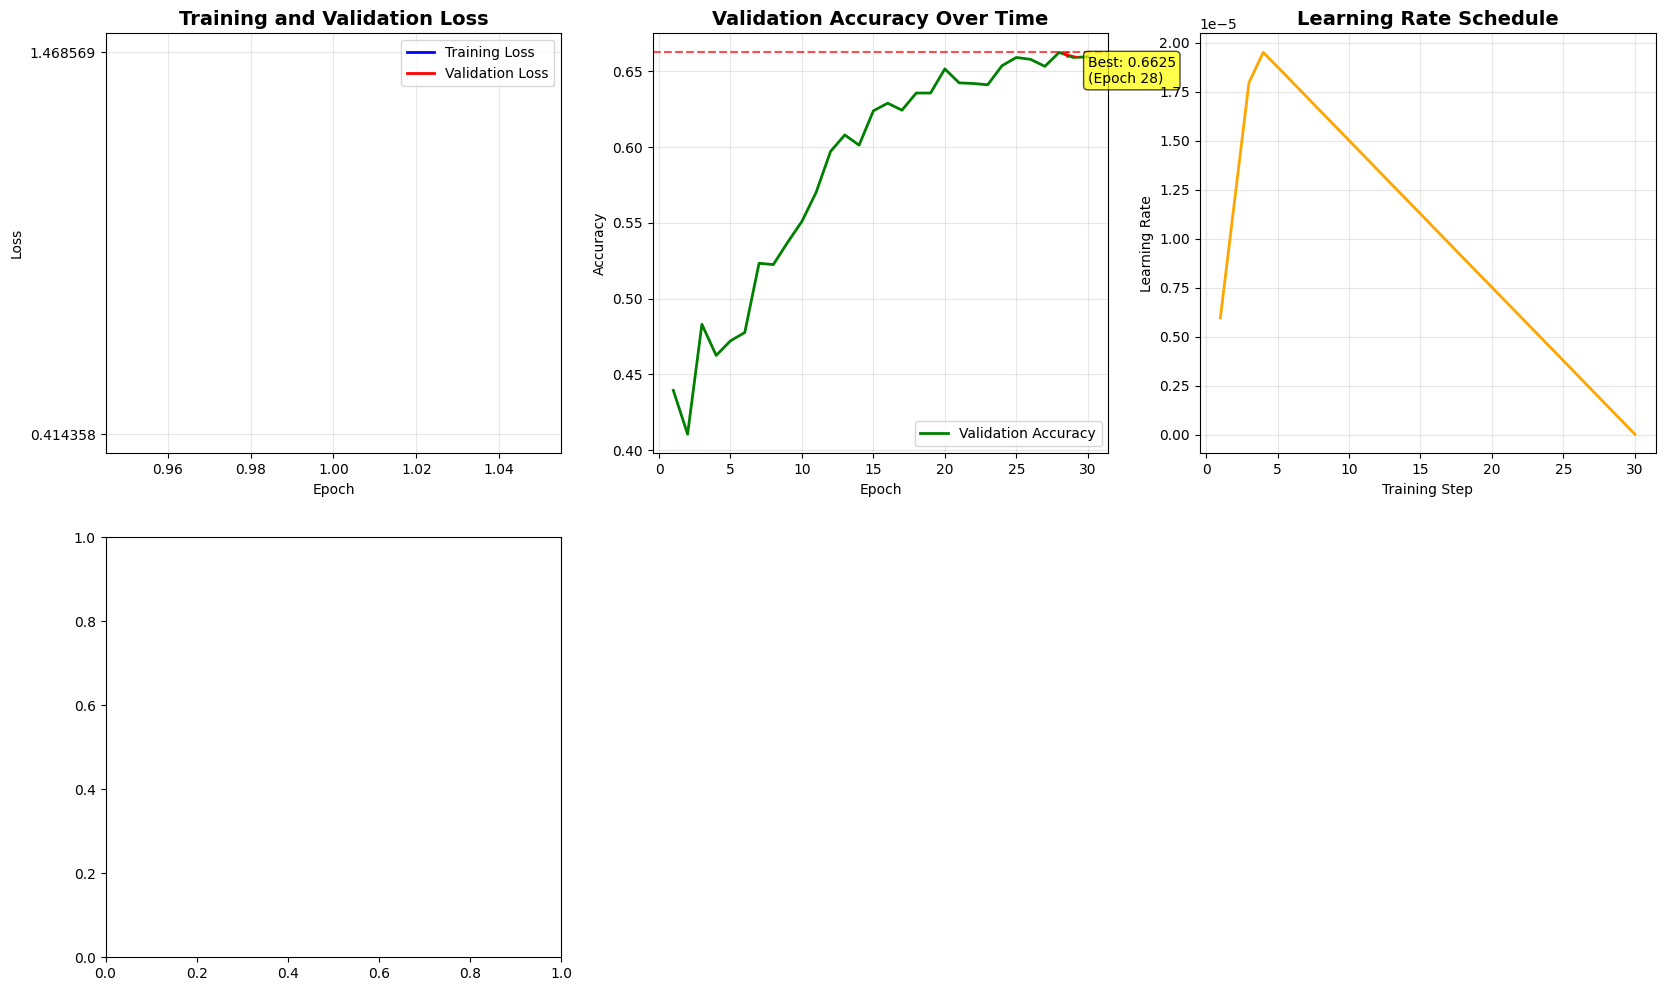

In [ ]:
# Run All Training
print("Starting DistilBERT training for 30 epochs...")
results = train_and_evaluate_distilbert_30_epochs(
    train_texts, val_texts, train_labels, val_labels,
    num_labels=len(label_encoder.classes_)
)

print(f"\n{'='*80}")
print("TRAINING COMPLETED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"Final Results:")
print(f"- Model: {results['model']}")
print(f"- Training Time: {results['training_time']:.2f} seconds ({results['training_time']/3600:.2f} hours)")
print(f"- Final Accuracy: {results['accuracy']:.4f}")
print(f"- Inference Time (100 samples): {results['inference_time']:.4f} seconds")
print(f"- Model saved at: {results['model_path']}")
print(f"\nModel is ready for deployment!")